# Basic Asset Analysis

How to evaluate the performance of your assets?
Optimize your portfolio by reviewing the statistics of your stocks.

The goal is to generate an objective measure to validate the potential win against the risk. This method is know as the CAPM method. What we would like to see:
- Risk?
- Opportunity?
- Is the asset over- or under valued? (undervalued = potential that it will do well in the future)

## 1. Importing Libraries

In [1]:
import pandas_datareader as pdr
import numpy as np
import datetime as dt
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Calculating Beta
Beta expresses how "dynamic" an asset reacts to market fluctuations. A high beta means high risk, but also high opportunity, depending on the market.
- Beta < 1: More stable, but also less growth opportunity
- Beta > 1: More risky, but also higher win opportunity

### Process
- Get raw stock data of the market and the stocks of interest (can be 1 year, 3 years or other timeframe). Typically the S&P500 (Symbol "^GSPC") is used as the representation of the market data.
- Transform raw data into a dataframe with returns
- Calculate Beta
- Calculate the expected rate of return (CAPM method)
- Interprete the results

In [3]:
tickers = ['XIC.TO', '^GSPC', 'SHOP', 'TSLA', 'VFV.TO', 'VDY.TO']
start = dt.datetime(2018, 12, 24)
end = dt.datetime(2021, 12, 24)
df_stocks = pdr.get_data_yahoo(tickers, start, end, interval="d")

df_stocks = df_stocks['Adj Close']

df_stocks

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,20.099089,2351.100098,119.099998,59.077999,54.506874,25.446142
2018-12-26,NaN,2467.699951,130.210007,65.218002,NaN,NaN
2018-12-27,20.646496,2488.830078,132.399994,63.226002,57.672108,26.051168
2018-12-28,20.764050,2485.739990,133.460007,66.774002,57.985275,26.280584
2018-12-31,20.929352,2506.850098,138.449997,66.559998,58.090950,26.368475
...,...,...,...,...,...,...
2021-12-20,32.810001,4568.020020,1282.170044,899.940002,105.099998,41.880001
2021-12-21,33.419998,4649.229980,1370.109985,938.530029,106.750000,42.380001
2021-12-22,33.660000,4696.560059,1385.630005,1008.869995,107.150002,42.680000


### Calculating Beta - Method 1

In [4]:
# Generating dataframe with returns
df_returns = np.log(df_stocks / df_stocks.shift())
df_returns

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-26,NaN,0.048403,0.089185,0.098877,NaN,NaN
2018-12-27,NaN,0.008526,0.016679,-0.031020,NaN,NaN
2018-12-28,0.005677,-0.001242,0.007974,0.054598,0.005415,0.008768
2018-12-31,0.007929,0.008457,0.036707,-0.003210,0.001821,0.003339
...,...,...,...,...,...,...
2021-12-20,-0.009706,-0.011453,-0.031650,-0.035616,-0.008149,-0.005002
2021-12-21,0.018421,0.017622,0.066337,0.041987,0.015577,0.011868
2021-12-22,0.007156,0.010129,0.011264,0.072271,0.003740,0.007054


In [7]:
cov = df_returns.cov()
var = df_returns['^GSPC'].var()
beta_xic = cov.loc['XIC.TO', '^GSPC'] / var
beta_shop = cov.loc['SHOP', '^GSPC'] / var
beta_tsla = cov.loc['TSLA', '^GSPC'] / var
beta_vfv = cov.loc['VFV.TO', '^GSPC'] / var
beta_vdy = cov.loc['VDY.TO', '^GSPC'] / var

In [8]:
print('Betas for XIC: {:1.2}, SHOPIFY: {:1.2}, Tesla: {:1.2}, Vanguard: {:1.2}, Vanguard: {:1.2}'.format(beta_xic, beta_shop, beta_tsla, beta_vfv, beta_vdy))

Betas for XIC: 0.8, SHOPIFY: 1.2, Tesla: 1.3, Vanguard: 0.87, Vanguard: 0.86


### Calculating Beta - Method 2

In [9]:
def calc_return(df):
    '''Function to generate a detaframe with returns
    - Input: Dataframe with raw stock data
    - Output: Dataframe with returns'''

    x = df.copy()
    
    for i in range(1, len(df)):
        x.iloc[i] = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1] * 100

    x.iloc[0] = 0

    return x

In [10]:
df_returns_alt = calc_return(df_stocks)
df_returns_alt

Symbols,XIC.TO,^GSPC,SHOP,TSLA,VFV.TO,VDY.TO
Date,,,,,,
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,NaN,4.959374,9.328303,10.393045,NaN,NaN
2018-12-27,NaN,0.856268,1.681889,-3.054372,NaN,NaN
2018-12-28,0.569364,-0.124158,0.800614,5.611616,0.543014,0.880636
2018-12-31,0.796098,0.849248,3.738940,-0.320491,0.182244,0.334432
...,...,...,...,...,...,...
2021-12-20,-0.965891,-1.138806,-3.115459,-3.498934,-0.811628,-0.498929
2021-12-21,1.859179,1.777793,6.858680,4.288067,1.569935,1.193887
2021-12-22,0.718138,1.018020,1.132757,7.494695,0.374709,0.707879


In [11]:
# NaN values will lead to an error in the polyfit calculation, so these values will be replaced with the previous values.
df_returns_alt.fillna(method="ffill", inplace=True)

In [13]:
beta_xic_a, alpha_xic_a = np.polyfit(df_returns_alt['^GSPC'], df_returns_alt['XIC.TO'], 1)
beta_shop_a, alpha_shop_a = np.polyfit(df_returns_alt['^GSPC'], df_returns_alt['SHOP'], 1)
beta_tsla_a, alpha_tsla_a = np.polyfit(df_returns_alt['^GSPC'], df_returns_alt['TSLA'], 1)
beta_vfv_a, alpha_vfv_a = np.polyfit(df_returns_alt['^GSPC'], df_returns_alt['VFV.TO'], 1)
beta_vdy_a, alpha_vdy_a = np.polyfit(df_returns_alt['^GSPC'], df_returns_alt['VDY.TO'], 1)

In [10]:
print('Betas for XIC: {:1.2}, SHOPIFY: {:1.2}, Tesla: {:1.2}, Vanguard: {:1.2}'.format(beta_xic_a, beta_shop_a, beta_tsla_a, beta_vfv_a))

Betas for XIC: 0.76, SHOPIFY: 1.2, Tesla: 1.3, Vanguard: 0.84


The results are slightly different, but close enough for the evaluation. This means it doesn't matter which methods are used in this case.

### Visualizing Beta

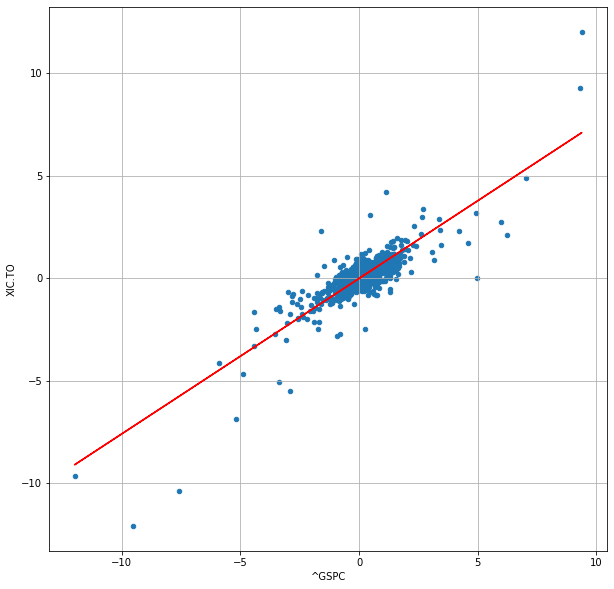

In [11]:
df_returns_alt.plot(kind='scatter', x = '^GSPC', y='XIC.TO', figsize=(10, 10))
plt.plot(df_returns_alt['^GSPC'], beta_xic_a * df_returns_alt['^GSPC'] + alpha_xic_a, '-', color='red')
plt.grid();

## 3. Calculating the Expected Rate of Return
The expected rate of return expresses a potential return rate that considers the relation to a risk free asset, the relation to the market (in our case S&P 500), and the Beta indicator.

![GitHub Logo](https://capital.com/files/glossary/[Infographic]%20Capital%20asset%20pricing%20model.png)

### Process
- Calculate the average market return for a year (Up to this point we dealt with daily returns.).
- 
